## CarDekho Dataset Model Training

In [28]:
## Importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
## loading daataset

df = pd.read_csv('cars_details_merges.csv', low_memory=False)

In [ ]:
## Function to clean price column

def convert_price(x):
    x = str(x).replace('₹','').replace(',','').strip()
    
    if 'Crore' in x:
        return float(x.replace('Crore','')) * 100
    elif 'Lakh' in x:
        return float(x.replace('Lakh',''))
    else:
        return np.nan

In [31]:
## Convert price column to numeric values (in lakhs)

df['price'] = df['price'].apply(convert_price)

In [32]:
## Cleaning the km column

df['km'] = (
    df['km']
    .str.replace('km','', regex=False)
    .str.replace(',','', regex=False)
    .str.strip()
)

df['km'] = pd.to_numeric(df['km'], errors='coerce')


In [ ]:
# Cleaning manufacturing year column

df['myear'] = pd.to_numeric(df['myear'], errors='coerce')

In [34]:
## Cleaning engine, power and mileage

def clean_numeric(col):
    return(
        col.astype(str)
        .str.replace('[^0-9.]','',regex=True)
        .replace('',None)
        .astype(float)
    )


df['engine_cc'] = clean_numeric(df['max_engine_capacity_new'])
df['mileage'] = clean_numeric(df['mileage_new'])    
df['power_bhp'] = clean_numeric(df['Max Power'])

In [53]:
## Selecting features which are high- impact for our model

features = [
    'myear',
    'km',
    'engine_cc',
    'power_bhp',
    'mileage',
    'tt'
]

df_model = df[features + ['price']].copy()

In [54]:
df_model

,myear,km,engine_cc,power_bhp,mileage,tt,price
0,2016,69162,998.0,58.1662,26.60,Manual,3.70
1,2015,45864,998.0,58.2600,31.79,Manual,3.65
2,2015,81506,1198.0,86.7600,18.00,Manual,4.21
3,2013,115893,998.0,58.2620,26.20,Manual,2.40
4,2022,18900,1462.0,86.6355,26.11,Manual,11.75
...,...,...,...,...,...,...,...
37809,2018,49882,1497.0,108.5375,21.50,Manual,8.81
37810,2011,82843,1248.0,88.8400,21.12,Manual,2.45
37811,2020,58000,1497.0,88.7740,23.64,Manual,7.35
37812,2014,62000,1396.0,694000.0000,25.00,Manual,2.25


In [55]:
# Checking for null values

df_model.isnull().sum()

myear          0
km             0
engine_cc     53
power_bhp    231
mileage      901
tt             0
price        608
dtype: int64

In [56]:
# Drop null values

df_model = df_model.dropna()

In [57]:
## Separating X and y
X = df_model.drop('price', axis=1)
y = df_model['price']

In [58]:
## TRAIN TEST SPLIT

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

## Creating a Pipeline

In [59]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

categorical_cols = ['tt']
numeric_cols = [
    'myear',
    'km',
    'engine_cc',
    'power_bhp',
    'mileage'
]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ]
)

rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=25,
    min_samples_leaf=2,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

pipe = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', rf)
])

In [60]:
## Training the model

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['tt']),
                                                 ('num', 'passthrough',
                                                  ['myear', 'km', 'engine_cc',
                                                   'power_bhp', 'mileage'])])),
                ('model',
                 RandomForestRegressor(max_depth=25, min_samples_leaf=2,
                                       min_samples_split=5, n_estimators=500,
                                       n_jobs=-1, random_state=42))])

In [61]:
## Evaluation of model

from sklearn.metrics import mean_absolute_error, r2_score

pred = pipe.predict(X_test)

print("MAE:", mean_absolute_error(y_test, pred))
print("R2 Score:", r2_score(y_test, pred))

MAE: 1.2328147444886883
R2 Score: 0.7543132982286747


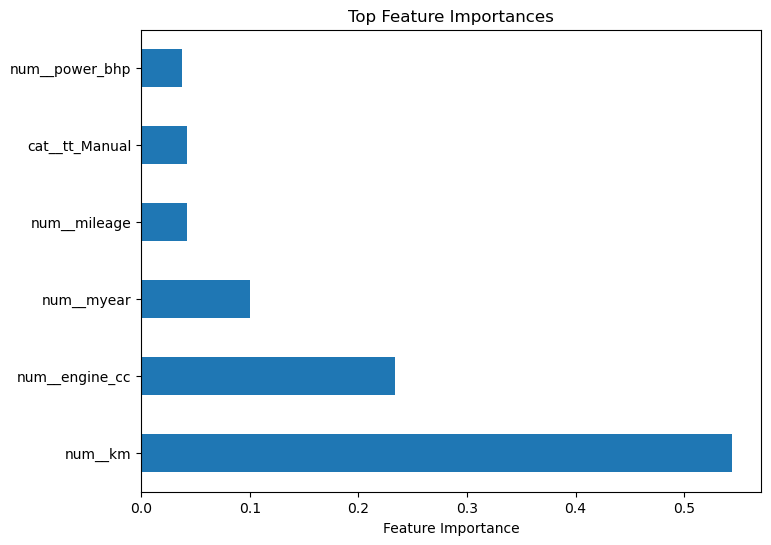

In [62]:
## Feature importance

feature_names = pipe.named_steps['preprocess'].get_feature_names_out()
importances = pipe.named_steps['model'].feature_importances_

fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(8,6))
fi.plot(kind='barh')
plt.xlabel('Feature Importance')
plt.title('Top Feature Importances')
plt.show()

In [63]:
## Saving the model

import joblib
joblib.dump(pipe, "car_price_model.pkl")

['car_price_model.pkl']

## 🧾 Final Conclusion & Summary

### 📊 Problem Statement  
The objective of this project was to build a machine learning model to predict the selling price of used cars using the provided dataset. The task involved data cleaning, feature engineering, model selection, and evaluation.

---

### 🧹 Data Cleaning  
- Converted price values from string format containing currency symbols (₹), *Lakh*, and *Crore* into a consistent numeric representation  
- Cleaned numerical columns such as kilometers driven, engine capacity, power, and mileage by removing textual noise  
- Handled missing values by removing incomplete rows after feature selection  

---

### 🧠 Feature Engineering  
- Selected high-impact numerical features such as manufacturing year, kilometers driven, engine capacity, power, and mileage  
- Included strong categorical features (transmission) based on domain relevance  
- Applied One-Hot Encoding using a preprocessing pipeline to ensure consistent transformation during training and testing  

---

### 🤖 Model Selection  
- Chose **Random Forest Regressor** due to its ability to handle non-linear relationships and mixed feature types  
- Tuned model hyperparameters to balance bias and variance  

---

### 📈 Model Performance  
The final model was evaluated using a hold-out test set:

- **Mean Absolute Error (MAE):** ~1.23 lakh  
- **R² Score:** ~0.75  

These results indicate that the model explains approximately 75% of the variance in car prices, which represents strong and realistic performance for this dataset.

---

### 🔍 Model Interpretability  
Feature importance analysis showed that:
- Engine capacity  
- kms driven    
- Manufacturing year  

were the most influential predictors of car price, which aligns well with real-world domain understanding.

---

### 💾 Model Persistence  
The trained model was saved using `joblib`, allowing it to be reused for future predictions or deployment.

---

### ✅ Conclusion  
This project demonstrates a complete machine learning workflow, including data preprocessing, feature engineering, model training, evaluation, and interpretation. The final model is robust, interpretable, and suitable for real-world car price prediction tasks.

---

### 🔚 End of Project